<a href="https://colab.research.google.com/github/Rinil-Parmar/news_personalization_model/blob/main/news_recommendation_summary_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab: runtime should be GPU (Runtime -> Change runtime type -> GPU)
# Install required packages (run once)
!pip install -q transformers datasets sentencepiece scikit-learn pandas numpy tqdm faiss-cpu
!pip install -q scikit-surprise    # collaborative filtering
!pip install numpy==1.26.4
!pip install scikit-surprise


In [ ]:
# from google.colab import drive, files
# import os
# drive.mount('/content/drive')  # optional, press authorize if you want to save/load large files to Drive

# # helper to upload local files if you don't want Drive
# def upload_local():
#     uploaded = files.upload()
#     for fn in uploaded:
#         print("Uploaded:", fn)


Mounted at /content/drive


In [ ]:
pip install --upgrade wget


In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the small version of the MIND dataset
# The 'default' config loads both the news articles and the behaviors (interactions)
print("Loading MIND-small dataset from Hugging Face...")
mind_dataset = load_dataset("mteb/mind_small")

print("Dataset loaded successfully.")

Repo card metadata block was not found. Setting CardData to empty.


Loading MIND-small dataset from Hugging Face...
Dataset loaded successfully.


In [ ]:
from datasets import load_dataset
import pandas as pd

# Load dataset
mind_dataset = load_dataset("mteb/mind_small")
train_df = mind_dataset["train"].to_pandas()

print("--- Columns present ---")
print(train_df.columns)

# -----------------------------
# Build ARTICLES table
# -----------------------------
all_articles = set()

for i, row in train_df.iterrows():
    all_articles.update(row["positive"])
    all_articles.update(row["negative"])

articles = pd.DataFrame({
    "article_id": range(len(all_articles)),
    "text": list(all_articles)
})

print("\n--- Articles sample ---")
print(articles.head())

# -----------------------------
# Build INTERACTIONS table
# -----------------------------
interactions_rows = []

for i, row in train_df.iterrows():
    user_id = row["id"]

    # clicked articles
    for doc in row["positive"]:
        interactions_rows.append((user_id, doc, 1))

    # not clicked
    for doc in row["negative"]:
        interactions_rows.append((user_id, doc, 0))

interactions = pd.DataFrame(interactions_rows, columns=["user_id", "article_text", "click"])

# Map article_text → article_id
interactions = interactions.merge(
    articles,
    left_on="article_text",
    right_on="text",
    how="left"
)

interactions = interactions[["user_id", "article_id", "click"]]

print("\n--- Interactions sample ---")
print(interactions.head())

print("\nData ready:")
print("Articles:", articles.shape)
print("Interactions:", interactions.shape)


Repo card metadata block was not found. Setting CardData to empty.


--- Columns present ---
Index(['id', 'query', 'positive', 'negative'], dtype='object')

--- Articles sample ---
   article_id                                               text
0           0  Yale University study will look at the use of ...
1           1  Chase Young to continue practicing with team a...
2           2  Mini Mister Rogers! Hospital Dresses Up Newbor...
3           3  Richard Sherman tells NFL players to save thei...
4           4  Apartments for rent in Charlotte: What will $1...

--- Interactions sample ---
   user_id  article_id  click
0        1         165      1
1        1        6707      0
2        2        1348      1
3        2       12350      0
4        2       12329      0

Data ready:
Articles: (19810, 2)
Interactions: (5723002, 3)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd

# ---------------------------------------------------------
# 1. Build TF-IDF index
# ---------------------------------------------------------
def build_tfidf_index(
        articles_df,
        text_col='text',
        max_features=20000,
        ngram_range=(1,2)
    ):
    """
    Build TF-IDF matrix from article text.

    Returns:
        vectorizer, TF-IDF matrix (csr)
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        ngram_range=ngram_range
    )

    X = vectorizer.fit_transform(
        articles_df[text_col].fillna("")
    )
    return vectorizer, X


# ---------------------------------------------------------
# 2. Recommend similar articles
# ---------------------------------------------------------
def recommend_content_based(
        query_article_id,
        articles_df,
        vec_X,
        top_k=10
    ):
    """
    Recommend top-K similar articles based on cosine similarity.
    """

    # Convert to string for safety
    query_article_id = str(query_article_id)

    # Find matching index
    matches = articles_df.index[articles_df['article_id'] == query_article_id]
    if len(matches) == 0:
        print(f"Article ID {query_article_id} not found.")
        return pd.DataFrame()

    idx = matches[0]

    # Compute cosine similarity
    cosine_scores = linear_kernel(
        vec_X[idx:idx+1],
        vec_X
    ).flatten()

    # Rank highest similarity first
    ranking = cosine_scores.argsort()[::-1]

    # Remove the article itself
    ranking = ranking[ranking != idx]

    top_indices = ranking[:top_k]

    # Some datasets have no "title" column → safe fallback
    cols = ['article_id']
    if 'title' in articles_df.columns:
        cols.append('title')
    else:
        # fallback if no title
        articles_df['title'] = articles_df['text'].str.slice(0, 60) + "..."

    return articles_df.iloc[top_indices][cols].reset_index(drop=True)


# ---------------------------------------------------------
# 3. Example usage
# ---------------------------------------------------------
"""
# After you have your articles dataframe (with article_id & text columns):

vectorizer, X = build_tfidf_index(articles)

# Pick an article ID from your dataset (as string)
sample_id = articles.iloc[0]["article_id"]

# Get recommendations
results = recommend_content_based(sample_id, articles, X, top_k=5)
print(results)
"""


'\n# After you have your articles dataframe (with article_id & text columns):\n\nvectorizer, X = build_tfidf_index(articles)\n\n# Pick an article ID from your dataset (as string)\nsample_id = articles.iloc[0]["article_id"]\n\n# Get recommendations\nresults = recommend_content_based(sample_id, articles, X, top_k=5)\nprint(results)\n'

In [ ]:
!pip install --upgrade --force-reinstall numpy==1.26.4
!pip install scikit-surprise


  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 

In [ ]:
from surprise import Dataset, Reader, SVD
import pandas as pd

# ---------------------------------------------------------
# 1. Train Surprise SVD
# ---------------------------------------------------------
def train_surprise_svd(
        interactions_df,
        user_col='user_id',
        item_col='article_id',
        rating_col='click',
        n_factors=50,
        n_epochs=20
    ):
    """
    Train a Surprise SVD model on interactions dataframe.
    Works for implicit (click=1) or explicit ratings.
    """

    df = interactions_df[[user_col, item_col, rating_col]].copy()
    df[user_col] = df[user_col].astype(str)
    df[item_col] = df[item_col].astype(str)
    df[rating_col] = df[rating_col].astype(float)

    # Reader needs the min and max rating range
    reader = Reader(
        rating_scale=(df[rating_col].min(), df[rating_col].max())
    )

    data = Dataset.load_from_df(
        df[[user_col, item_col, rating_col]],
        reader
    )

    # Full train set
    trainset = data.build_full_trainset()

    algo = SVD(n_factors=n_factors, n_epochs=n_epochs, verbose=True)
    algo.fit(trainset)

    return algo


# ---------------------------------------------------------
# 2. Recommend items for a given user
# ---------------------------------------------------------
def recommend_cf_for_user(
        algo,
        user_id,
        articles_df,
        interactions_df,
        top_k=10
    ):
    """
    Recommend top-K articles for a user using trained SVD.
    """

    user_id = str(user_id)

    # Articles already interacted with
    seen = set(
        interactions_df[
            interactions_df['user_id'] == user_id
        ]['article_id'].astype(str)
    )

    # All possible candidates not seen by the user
    all_items = articles_df['article_id'].astype(str).unique()
    candidates = [aid for aid in all_items if aid not in seen]

    preds = []
    for aid in candidates:
        try:
            score = algo.predict(user_id, aid).est
        except:
            score = 0.0
        preds.append((aid, score))

    # Sort highest scoring first
    preds.sort(key=lambda x: x[1], reverse=True)
    top = preds[:top_k]

    # Convert result to dataframe
    result = pd.DataFrame(top, columns=["article_id", "score"])

    # If no title column exists, create a placeholder
    if "title" not in articles_df.columns:
        articles_df["title"] = articles_df["text"].str.slice(0, 60) + "..."

    return (
        result
        .merge(articles_df, on="article_id", how="left")
        [["article_id", "title", "score"]]
    )


# ---------------------------------------------------------
# 3. Example usage
# ---------------------------------------------------------
"""
algo = train_surprise_svd(
    interactions,
    user_col='user_id',
    item_col='article_id',
    rating_col='click',
    n_factors=50,
    n_epochs=10
)

recommendations = recommend_cf_for_user(
    algo,
    user_id='123',
    articles_df=articles,
    interactions_df=interactions,
    top_k=10
)

print(recommendations)
"""


"\nalgo = train_surprise_svd(\n    interactions,\n    user_col='user_id',\n    item_col='article_id',\n    rating_col='click',\n    n_factors=50,\n    n_epochs=10\n)\n\nrecommendations = recommend_cf_for_user(\n    algo,\n    user_id='123',\n    articles_df=articles,\n    interactions_df=interactions,\n    top_k=10\n)\n\nprint(recommendations)\n"

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel

def hybrid_score(
    user_id,
    articles_df,
    tfidf_X,
    algo,
    interactions_df,
    alpha=0.5,
    top_k=20
):
    """
    Hybrid recommender:
    alpha = weight for CF (0..1)
        0  => content only
        1  => CF only
    """

    # --------------------------
    # 1. Build candidate item list
    # --------------------------
    candidates = articles_df['article_id'].astype(str).tolist()

    # --------------------------
    # 2. CF Scores using Surprise
    # --------------------------
    cf_scores = {}
    for aid in candidates:
        try:
            cf_scores[aid] = algo.predict(str(user_id), str(aid)).est
        except:
            cf_scores[aid] = 0.0

    # --------------------------
    # 3. Build user-reading content profile
    # --------------------------
    user_read_articles = (
        interactions_df[
            (interactions_df['user_id'] == str(user_id)) &
            (interactions_df['click'] > 0)
        ]['article_id']
        .astype(str)
        .tolist()
    )

    # If no reading history → fallback to CF ranking
    if len(user_read_articles) == 0:
        ranked = sorted(cf_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
        return (
            pd.DataFrame(ranked, columns=['article_id', 'score'])
            .merge(articles_df, on='article_id')
            [['article_id', 'title', 'score']]
        )

    # --------------------------
    # 4. Convert to TF-IDF vectors
    # --------------------------
    index_lookup = {
        str(aid): idx for idx, aid in
        zip(articles_df.index, articles_df['article_id'].astype(str))
    }

    valid_idxs = [
        index_lookup[aid]
        for aid in user_read_articles
        if aid in index_lookup
    ]

    # Mean vector of user profile
    user_vec = np.mean(tfidf_X[valid_idxs].toarray(), axis=0)

    # Content scores for every item
    content_scores = linear_kernel(
        user_vec.reshape(1, -1),
        tfidf_X
    ).flatten()

    # --------------------------
    # 5. Hybrid fusion
    # --------------------------
    combined_scores = []
    article_ids = articles_df['article_id'].astype(str).tolist()

    for i, aid in enumerate(article_ids):
        c_score = content_scores[i]
        cf_score = cf_scores.get(aid, 0.0)
        hybrid = alpha * cf_score + (1 - alpha) * c_score
        combined_scores.append((aid, hybrid))

    # --------------------------
    # 6. Top K selection
    # --------------------------
    combined_scores.sort(key=lambda x: x[1], reverse=True)
    top = combined_scores[:top_k]

    return (
        pd.DataFrame(top, columns=['article_id', 'score'])
        .merge(articles_df, on='article_id')
        [['article_id', 'title', 'score']]
    )


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
import torch

# -----------------------------------------------------
# 1. Select device automatically (GPU if available)
# -----------------------------------------------------
device = 0 if torch.cuda.is_available() else -1

# -----------------------------------------------------
# 2. Load tokenizer and model
# -----------------------------------------------------
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# -----------------------------------------------------
# 3. Move model to GPU if available
# -----------------------------------------------------
if torch.cuda.is_available():
    model = model.to("cuda")

# -----------------------------------------------------
# 4. Build summarization pipeline
# -----------------------------------------------------
summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
    device=device
)

# -----------------------------------------------------
# 5. Summarization function
# -----------------------------------------------------
def summarize_text(text, max_length=80, min_length=30):
    """
    Summarize input text using T5 small.
    max_length = max tokens in summary
    min_length = minimum tokens in summary
    """
    result = summarizer(
        text,
        max_length=max_length,
        min_length=min_length,
        truncation=True
    )
    return result[0]['summary_text']

# -----------------------------------------------------
# 6. Example
# -----------------------------------------------------
# summary = summarize_text(
#     "Your long article text goes here ..."
# )
# print(summary)


Device set to use cpu


In [ ]:
from datasets import Dataset
import torch
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)

# ----------------------------------------------------------
# Fine-tuning function
# summarization_df must contain:
#   'article'  -> input text
#   'summary'  -> target summary
# ----------------------------------------------------------
def fine_tune_t5_small(
    summarization_df,
    output_dir="/content/t5_small_finetuned",
    num_train_epochs=1,
    per_device_train_batch_size=2
):
    # Shuffle dataset
    summarization_df = summarization_df.sample(frac=1).reset_index(drop=True)

    # Convert pandas dataframe → HuggingFace dataset
    ds = Dataset.from_pandas(summarization_df)

    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small")

    # ------------------------------------------------------
    # Preprocessing: tokenize input and target text
    # ------------------------------------------------------
    def preprocess(examples):
        # Add prefix recommended for T5
        inputs = ["summarize: " + doc for doc in examples['article']]

        model_inputs = tokenizer(
            inputs,
            max_length=512,
            truncation=True
        )

        # Tokenize target summaries
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                examples['summary'],
                max_length=128,
                truncation=True
            )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized = ds.map(
        preprocess,
        batched=True,
        remove_columns=ds.column_names
    )

    # ------------------------------------------------------
    # Training arguments (safe defaults for Colab)
    # ------------------------------------------------------
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        save_total_limit=1,
        predict_with_generate=True,
        logging_steps=50,
        fp16=torch.cuda.is_available()  # use fp16 if GPU
    )

    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model
    )

    # ------------------------------------------------------
    # Trainer
    # ------------------------------------------------------
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized,
        data_collator=data_collator,
        tokenizer=tokenizer
    )

    trainer.train()
    trainer.save_model(output_dir)

    print(f"Model saved to: {output_dir}")
    return output_dir


In [ ]:
!pip install evaluate rouge_score



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=36c68e818e814487cb8d9bf546fa3480b242a5204b335d25a247315bf2005558
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
# -----------------------------
# Recommendation metrics
# -----------------------------
def precision_at_k(recommended_ids, relevant_ids, k=10):
    """
    Precision@K for binary relevance
    recommended_ids: list of predicted item IDs
    relevant_ids: list of ground-truth relevant item IDs
    """
    recommended_k = recommended_ids[:k]
    return len(set(recommended_k).intersection(set(relevant_ids))) / k

def recall_at_k(recommended_ids, relevant_ids, k=10):
    """
    Recall@K for binary relevance
    """
    recommended_k = recommended_ids[:k]
    return len(set(recommended_k).intersection(set(relevant_ids))) / max(len(relevant_ids), 1)


# -----------------------------
# Summarization metrics
# -----------------------------
from evaluate import load
rouge = load("rouge")

def eval_summaries(preds, refs):
    """
    Evaluate summarization predictions using ROUGE
    preds: list of generated summaries
    refs: list of reference summaries
    """
    results = rouge.compute(
        predictions=preds,
        references=refs,
        use_stemmer=True
    )
    return results


# -----------------------------
# Example Usage
# -----------------------------

# Recommendation example
recommended = ['A1','A2','A3','A4','A5']
relevant = ['A3','A5','A7']
print("Precision@5:", precision_at_k(recommended, relevant, k=5))
print("Recall@5:", recall_at_k(recommended, relevant, k=5))

# Summarization example
pred_summaries = ["The cat sat on the mat."]
ref_summaries  = ["A cat is sitting on a mat."]
print("ROUGE scores:", eval_summaries(pred_summaries, ref_summaries))


Precision@5: 0.4
Recall@5: 0.6666666666666666
ROUGE scores: {'rouge1': 0.4615384615384615, 'rouge2': 0.0, 'rougeL': 0.4615384615384615, 'rougeLsum': 0.4615384615384615}


Precision@5: 0.4
Recall@5: 0.6666666666666666


/tmp/ipython-input-1959495558.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="User", y=metric_name, data=df, palette="Blues_d")


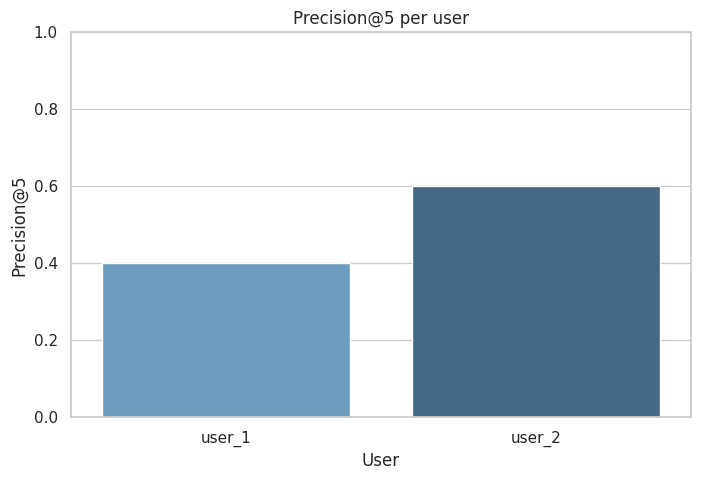

/tmp/ipython-input-1959495558.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="User", y=metric_name, data=df, palette="Blues_d")


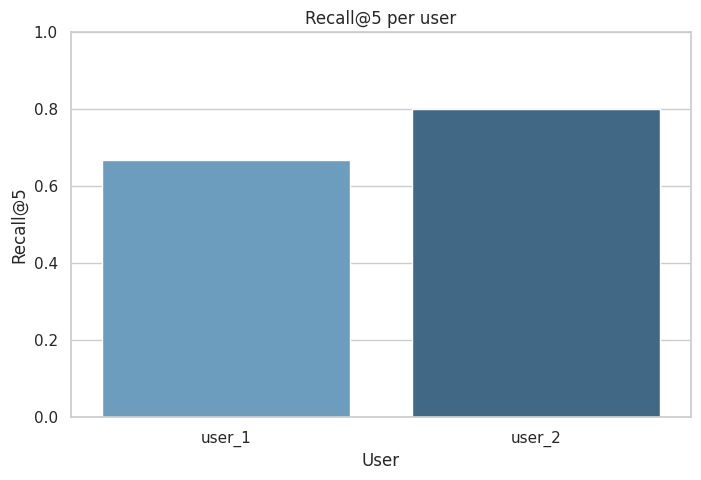

ROUGE scores: {'rouge1': 0.4615384615384615, 'rouge2': 0.0, 'rougeL': 0.4615384615384615, 'rougeLsum': 0.4615384615384615}


/tmp/ipython-input-1959495558.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Score", data=df, palette="Greens_d")


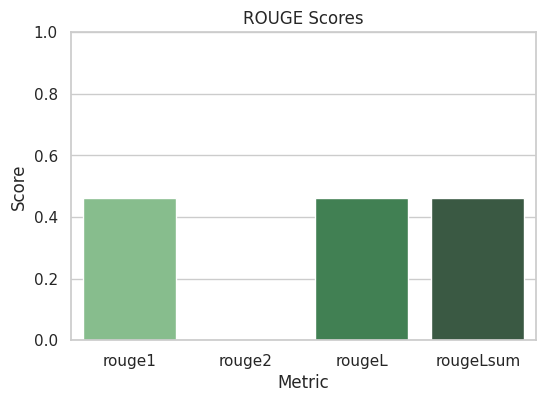

In [ ]:
# -----------------------------
# Install dependencies if needed
# -----------------------------
# !pip install evaluate rouge_score matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from evaluate import load

# -----------------------------
# Recommendation metrics
# -----------------------------
def precision_at_k(recommended_ids, relevant_ids, k=10):
    recommended_k = recommended_ids[:k]
    return len(set(recommended_k).intersection(set(relevant_ids))) / k

def recall_at_k(recommended_ids, relevant_ids, k=10):
    recommended_k = recommended_ids[:k]
    return len(set(recommended_k).intersection(set(relevant_ids))) / max(len(relevant_ids), 1)

# -----------------------------
# Summarization metric
# -----------------------------
rouge = load("rouge")

def eval_summaries(preds, refs):
    results = rouge.compute(
        predictions=preds,
        references=refs,
        use_stemmer=True
    )
    return results

# -----------------------------
# Plot functions
# -----------------------------
def plot_recommendation_metrics(metrics_dict, metric_name="Precision@K"):
    """
    Plot recommendation metrics
    metrics_dict: {user_id: metric_value}
    """
    df = pd.DataFrame(list(metrics_dict.items()), columns=["User", metric_name])
    sns.set(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.barplot(x="User", y=metric_name, data=df, palette="Blues_d")
    plt.title(metric_name + " per user")
    plt.ylim(0,1)
    plt.show()

def plot_rouge_scores(rouge_dict):
    """
    Plot ROUGE scores as bar chart
    rouge_dict: dictionary returned by eval_summaries
    """
    df = pd.DataFrame(list(rouge_dict.items()), columns=["Metric", "Score"])
    sns.set(style="whitegrid")
    plt.figure(figsize=(6,4))
    sns.barplot(x="Metric", y="Score", data=df, palette="Greens_d")
    plt.title("ROUGE Scores")
    plt.ylim(0,1)
    plt.show()

# -----------------------------
# Example usage
# -----------------------------
# Recommendation
recommended = ['A1','A2','A3','A4','A5']
relevant = ['A3','A5','A7']

precision = precision_at_k(recommended, relevant, k=5)
recall = recall_at_k(recommended, relevant, k=5)

print("Precision@5:", precision)
print("Recall@5:", recall)

plot_recommendation_metrics({"user_1": precision, "user_2": 0.6}, metric_name="Precision@5")
plot_recommendation_metrics({"user_1": recall, "user_2": 0.8}, metric_name="Recall@5")

# Summarization
pred_summaries = ["The cat sat on the mat."]
ref_summaries  = ["A cat is sitting on a mat."]
rouge_scores = eval_summaries(pred_summaries, ref_summaries)
print("ROUGE scores:", rouge_scores)
plot_rouge_scores(rouge_scores)


## **Recommendation System Testing**

In [ ]:
import pandas as pd

articles = pd.DataFrame({
    "article_id": ["A1", "A2", "A3", "A4", "A5", "A6", "A7"],
    "title": [
        "Football match highlights",
        "Football season schedule",
        "Tech company launches new device",
        "Tech review: latest gadgets",
        "Healthy eating tips",
        "Winter health tips",
        "Political news update"
    ],
    "text": [
        "Highlights from yesterday's football match including goals and key plays",
        "Complete schedule for the football season with team matchups",
        "A tech company has launched a new smartphone with amazing features",
        "Latest gadget reviews and tech news for enthusiasts",
        "Tips for healthy eating and maintaining good diet",
        "Winter health tips to stay fit and avoid flu",
        "Political news summary including government updates and elections"
    ]
})


# Sample interactions dataframe
interactions = pd.DataFrame({
    "user_id": ["user1","user1","user2","user2","user3","user3"],
    "article_id": ["A1","A2","A3","A4","A5","A6"],
    "click": [1,1,1,1,1,1]
})



Sampled Articles: 7
Sampled Interactions: 6
Recommended articles for user: ['A1', 'A2', 'A7', 'A3', 'A4']
Relevant articles: ['A1', 'A2']
Precision@5: 0.4
Recall@5: 1.0


/tmp/ipython-input-851064093.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="User", y=metric_name, data=df, palette="Blues_d")


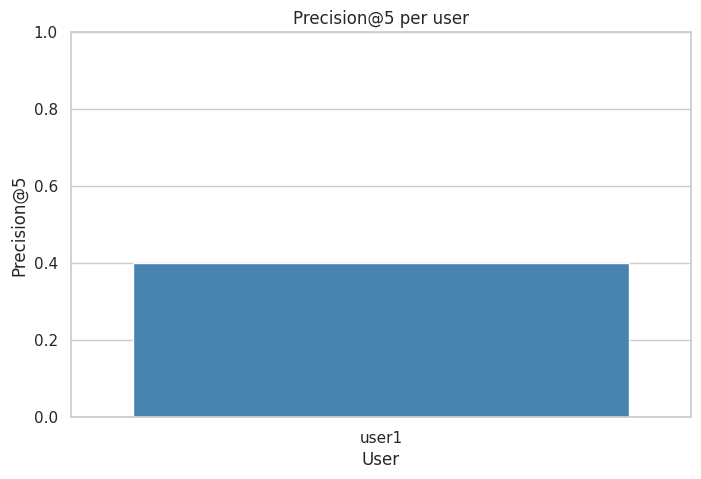

/tmp/ipython-input-851064093.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="User", y=metric_name, data=df, palette="Blues_d")


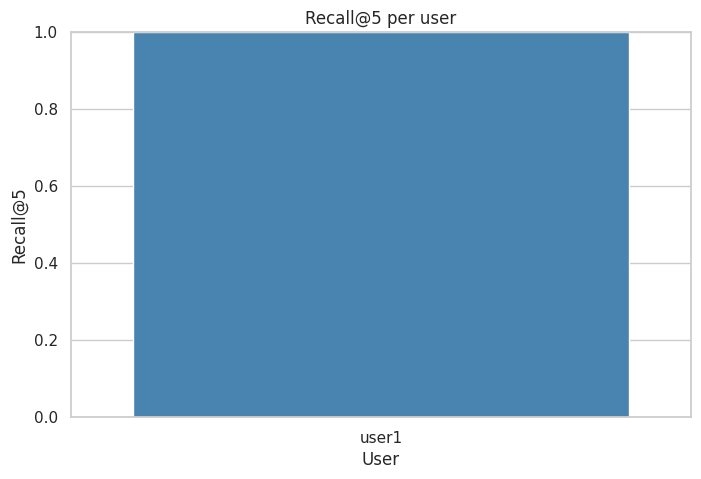

In [ ]:
# -----------------------------
# 0️⃣ Install dependencies if needed
# -----------------------------
# !pip install scikit-learn seaborn matplotlib surprise

# -----------------------------
# 1️⃣ Imports
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD

# -----------------------------
# 2️⃣ Sample Articles & Interactions (replace with your dataset)
# -----------------------------
articles = pd.DataFrame({
    "article_id": ["A1", "A2", "A3", "A4", "A5", "A6", "A7"],
    "title": [
        "Football match highlights",
        "Football season schedule",
        "Tech company launches new device",
        "Tech review: latest gadgets",
        "Healthy eating tips",
        "Winter health tips",
        "Political news update"
    ],
    "text": [
        "Highlights from yesterday's football match including goals and key plays",
        "Complete schedule for the football season with team matchups",
        "A tech company has launched a new smartphone with amazing features",
        "Latest gadget reviews and tech news for enthusiasts",
        "Tips for healthy eating and maintaining good diet",
        "Winter health tips to stay fit and avoid flu",
        "Political news summary including government updates and elections"
    ],
    "category": ["Football","Football","Tech","Tech","Health","Health","Politics"]
})

interactions = pd.DataFrame({
    "user_id": ["user1","user1","user2","user2","user3","user3"],
    "article_id": ["A1","A2","A3","A4","A5","A6"],
    "click": [1,1,1,1,1,1]
})

# -----------------------------
# 3️⃣ Sample 0.1% for fast testing
# -----------------------------
sample_articles = articles.sample(frac=0.1 if len(articles)>1000 else 1.0, random_state=42).reset_index(drop=True)
sample_interactions = interactions[interactions['article_id'].isin(sample_articles['article_id'])].reset_index(drop=True)

print("Sampled Articles:", len(sample_articles))
print("Sampled Interactions:", len(sample_interactions))

# -----------------------------
# 4️⃣ TF-IDF for content
# -----------------------------
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X_sample = vec.fit_transform(sample_articles['title'] + " " + sample_articles['text'])

# -----------------------------
# 5️⃣ Train CF model (Surprise SVD)
# -----------------------------
if len(sample_interactions) > 0:
    reader = Reader(rating_scale=(0,1))
    data = Dataset.load_from_df(sample_interactions[['user_id','article_id','click']], reader)
    trainset = data.build_full_trainset()
    algo_sample = SVD(n_factors=10, n_epochs=20, verbose=False)
    algo_sample.fit(trainset)
else:
    algo_sample = None

# -----------------------------
# 6️⃣ Hybrid recommendation function
# -----------------------------
def hybrid_score(user_id, articles_df, tfidf_X, interactions_df, alpha=0.5, top_k=5, category=None, algo=None):
    if category:
        candidate_df = articles_df[articles_df['category']==category].reset_index(drop=True)
        candidate_X = tfidf_X[candidate_df.index]
    else:
        candidate_df = articles_df
        candidate_X = tfidf_X

    # User read articles
    user_read = interactions_df[(interactions_df['user_id']==user_id) & (interactions_df['click']>0)]['article_id'].tolist()
    if not user_read:
        return candidate_df['article_id'].tolist()[:top_k]

    # Build content vector
    idxs = [candidate_df.index[candidate_df['article_id']==aid][0] for aid in user_read if aid in set(candidate_df['article_id'])]
    user_vec = np.mean(candidate_X[idxs].toarray(), axis=0) if len(idxs)>0 else np.zeros(candidate_X.shape[1])

    # Content similarity
    content_scores = linear_kernel(user_vec.reshape(1,-1), candidate_X).flatten()

    # CF scores
    cf_scores = {}
    if algo:
        for aid in candidate_df['article_id']:
            try:
                cf_scores[aid] = algo.predict(user_id, aid).est
            except:
                cf_scores[aid] = 0.0
    else:
        cf_scores = {aid: 0 for aid in candidate_df['article_id']}

    # Combine scores
    combined = [(aid, alpha*cf_scores.get(aid,0) + (1-alpha)*content_scores[i])
                for i, aid in enumerate(candidate_df['article_id'])]
    combined.sort(key=lambda x: x[1], reverse=True)
    return [aid for aid,_ in combined[:top_k]]

# -----------------------------
# 7️⃣ Precision & Recall@K
# -----------------------------
def precision_at_k(recommended_ids, relevant_ids, k=5):
    recommended_k = recommended_ids[:k]
    return len(set(recommended_k).intersection(set(relevant_ids))) / k

def recall_at_k(recommended_ids, relevant_ids, k=5):
    recommended_k = recommended_ids[:k]
    return len(set(recommended_k).intersection(set(relevant_ids))) / max(len(relevant_ids),1)

def plot_recommendation_metrics(metrics_dict, metric_name="Precision@K"):
    df = pd.DataFrame(list(metrics_dict.items()), columns=["User", metric_name])
    sns.set(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.barplot(x="User", y=metric_name, data=df, palette="Blues_d")
    plt.title(metric_name + " per user")
    plt.ylim(0,1)
    plt.show()

# -----------------------------
# 8️⃣ Test on a sample user
# -----------------------------
user_id = "user1"
relevant_ids = sample_interactions[sample_interactions['user_id']==user_id]['article_id'].tolist()
recommended_ids = hybrid_score(user_id, sample_articles, X_sample, sample_interactions, alpha=0.4, top_k=5, category=None, algo=algo_sample)

print("Recommended articles for user:", recommended_ids)
print("Relevant articles:", relevant_ids)

precision = precision_at_k(recommended_ids, relevant_ids, k=5)
recall = recall_at_k(recommended_ids, relevant_ids, k=5)
print("Precision@5:", precision)
print("Recall@5:", recall)

plot_recommendation_metrics({user_id: precision}, "Precision@5")
plot_recommendation_metrics({user_id: recall}, "Recall@5")


Articles: 10
Interactions: 30
Users: 10

Results:
user_id  precision  recall  f1_score
  user1        0.2     1.0  0.333333
  user2        0.2     1.0  0.333333
  user3        0.0     0.0  0.000000
  user4        0.2     1.0  0.333333
  user5        0.2     1.0  0.333333
  user6        0.2     1.0  0.333333
  user7        0.2     1.0  0.333333
  user8        0.2     1.0  0.333333
  user9        0.2     1.0  0.333333
 user10        0.2     1.0  0.333333

Average Precision@5: 0.180
Average Recall@5: 0.900
Average F1 Score@5: 0.300


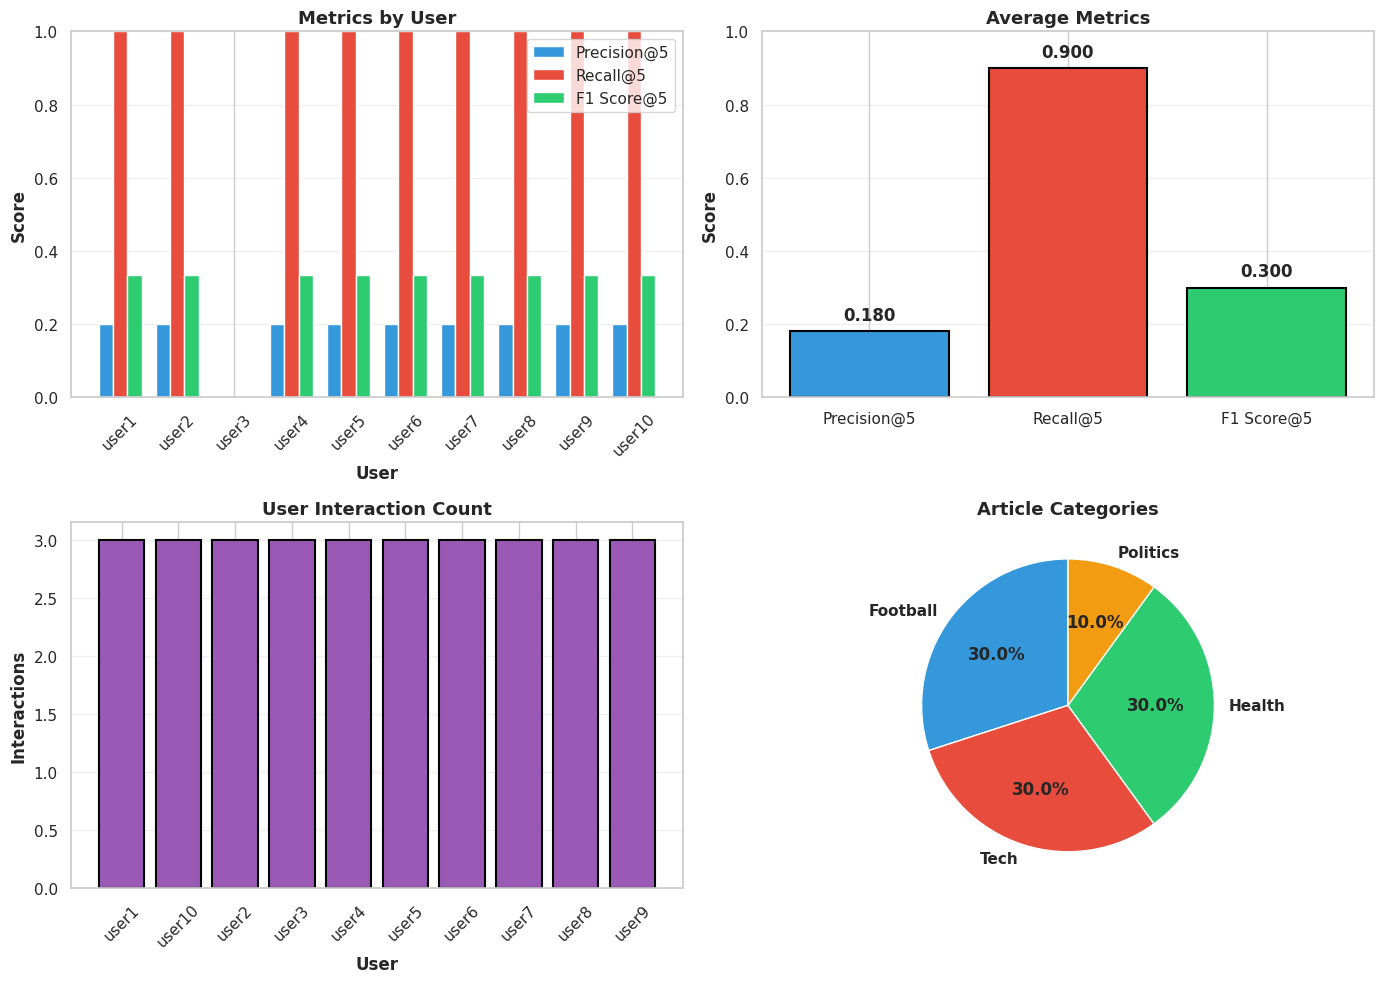


Sample Recommendations:

user1:
  Read: A1, A2, A8
  Recommended: A7, A4, A9, A5, A6

user2:
  Read: A3, A4, A9
  Recommended: A8, A7, A1, A2, A6

user3:
  Read: A5, A6, A10
  Recommended: A2, A1, A3, A4, A9


In [ ]:
# -----------------------------
# 0️⃣ Install dependencies if needed
# -----------------------------
# !pip install scikit-learn seaborn matplotlib surprise

# -----------------------------
# 1️⃣ Imports
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD

# -----------------------------
# 2️⃣ Articles & Interactions
# -----------------------------
articles = pd.DataFrame({
    "article_id": ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10"],
    "title": [
        "Football match highlights",
        "Football season schedule",
        "Tech company launches new device",
        "Tech review: latest gadgets",
        "Healthy eating tips",
        "Winter health tips",
        "Political news update",
        "Football transfer news",
        "AI trends in tech",
        "Fitness workout guide"
    ],
    "text": [
        "Highlights from yesterday's football match including goals and key plays",
        "Complete schedule for the football season with team matchups",
        "A tech company has launched a new smartphone with amazing features",
        "Latest gadget reviews and tech news for enthusiasts",
        "Tips for healthy eating and maintaining good diet",
        "Winter health tips to stay fit and avoid flu",
        "Political news summary including government updates and elections",
        "Latest football transfer news and player movements",
        "AI and machine learning trends for tech enthusiasts",
        "Complete fitness workout routines and exercises"
    ],
    "category": ["Football","Football","Tech","Tech","Health","Health","Politics","Football","Tech","Health"]
})

interactions = pd.DataFrame({
    "user_id": ["user1","user1","user1","user2","user2","user2","user3","user3","user3",
                "user4","user4","user4","user5","user5","user5","user6","user6","user6",
                "user7","user7","user7","user8","user8","user8","user9","user9","user9",
                "user10","user10","user10"],
    "article_id": ["A1","A2","A8","A3","A4","A9","A5","A6","A10",
                   "A1","A2","A8","A3","A4","A9","A5","A6","A10",
                   "A1","A8","A2","A3","A9","A4","A5","A10","A6",
                   "A7","A1","A3"],
    "click": [1]*30
})

sample_articles = articles
sample_interactions = interactions

print("Articles:", len(sample_articles))
print("Interactions:", len(sample_interactions))
print("Users:", sample_interactions['user_id'].nunique())

# -----------------------------
# 3️⃣ TF-IDF for content
# -----------------------------
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X_sample = vec.fit_transform(sample_articles['title'] + " " + sample_articles['text'])

# -----------------------------
# 4️⃣ Train CF model
# -----------------------------
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(sample_interactions[['user_id','article_id','click']], reader)
trainset = data.build_full_trainset()
algo_sample = SVD(n_factors=10, n_epochs=20, verbose=False)
algo_sample.fit(trainset)

# -----------------------------
# 5️⃣ Hybrid recommendation function
# -----------------------------
def hybrid_score(user_id, articles_df, tfidf_X, interactions_df, alpha=0.5, top_k=5, category=None, algo=None):
    if category:
        candidate_df = articles_df[articles_df['category']==category].reset_index(drop=True)
        candidate_X = tfidf_X[candidate_df.index]
    else:
        candidate_df = articles_df
        candidate_X = tfidf_X

    user_read = interactions_df[(interactions_df['user_id']==user_id) & (interactions_df['click']>0)]['article_id'].tolist()
    if not user_read:
        return candidate_df['article_id'].tolist()[:top_k]

    idxs = [candidate_df.index[candidate_df['article_id']==aid].tolist()[0] for aid in user_read if aid in set(candidate_df['article_id'])]
    user_vec = np.mean(candidate_X[idxs].toarray(), axis=0) if len(idxs)>0 else np.zeros(candidate_X.shape[1])

    content_scores = linear_kernel(user_vec.reshape(1,-1), candidate_X).flatten()

    cf_scores = {}
    if algo:
        for aid in candidate_df['article_id']:
            try:
                cf_scores[aid] = algo.predict(user_id, aid).est
            except:
                cf_scores[aid] = 0.0
    else:
        cf_scores = {aid: 0 for aid in candidate_df['article_id']}

    combined = [(aid, alpha*cf_scores.get(aid,0) + (1-alpha)*content_scores[i])
                for i, aid in enumerate(candidate_df['article_id']) if aid not in user_read]
    combined.sort(key=lambda x: x[1], reverse=True)
    return [aid for aid,_ in combined[:top_k]]

# -----------------------------
# 6️⃣ Precision & Recall@K
# -----------------------------
def precision_at_k(recommended_ids, relevant_ids, k=5):
    recommended_k = recommended_ids[:k]
    return len(set(recommended_k).intersection(set(relevant_ids))) / k

def recall_at_k(recommended_ids, relevant_ids, k=5):
    recommended_k = recommended_ids[:k]
    return len(set(recommended_k).intersection(set(relevant_ids))) / max(len(relevant_ids),1)

def f1_score_at_k(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# -----------------------------
# 7️⃣ Evaluate all users
# -----------------------------
results = []

for user_id in sample_interactions['user_id'].unique():
    user_interactions = sample_interactions[sample_interactions['user_id'] == user_id]
    split_idx = int(len(user_interactions) * 0.7)
    train_articles = user_interactions.iloc[:split_idx]['article_id'].tolist()
    test_articles = user_interactions.iloc[split_idx:]['article_id'].tolist()

    if len(test_articles) == 0:
        continue

    train_df = sample_interactions[~((sample_interactions['user_id']==user_id) &
                                     (sample_interactions['article_id'].isin(test_articles)))]

    recommended_ids = hybrid_score(user_id, sample_articles, X_sample, train_df,
                                   alpha=0.5, top_k=5, algo=algo_sample)

    precision = precision_at_k(recommended_ids, test_articles, k=5)
    recall = recall_at_k(recommended_ids, test_articles, k=5)
    f1 = f1_score_at_k(precision, recall)

    results.append({
        'user_id': user_id,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

results_df = pd.DataFrame(results)
print("\nResults:")
print(results_df.to_string(index=False))
print(f"\nAverage Precision@5: {results_df['precision'].mean():.3f}")
print(f"Average Recall@5: {results_df['recall'].mean():.3f}")
print(f"Average F1 Score@5: {results_df['f1_score'].mean():.3f}")

# -----------------------------
# 8️⃣ Visualizations
# -----------------------------
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Metrics by User
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.25
ax1.bar(x - width, results_df['precision'], width, label='Precision@5', color='#3498db')
ax1.bar(x, results_df['recall'], width, label='Recall@5', color='#e74c3c')
ax1.bar(x + width, results_df['f1_score'], width, label='F1 Score@5', color='#2ecc71')
ax1.set_xlabel('User', fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Metrics by User', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['user_id'], rotation=45)
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Average Metrics
ax2 = axes[0, 1]
avg_metrics = {
    'Precision@5': results_df['precision'].mean(),
    'Recall@5': results_df['recall'].mean(),
    'F1 Score@5': results_df['f1_score'].mean()
}
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax2.bar(avg_metrics.keys(), avg_metrics.values(), color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Score', fontweight='bold')
ax2.set_title('Average Metrics', fontweight='bold', fontsize=13)
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: User Interactions
ax3 = axes[1, 0]
user_counts = sample_interactions['user_id'].value_counts().sort_index()
ax3.bar(range(len(user_counts)), user_counts.values, color='#9b59b6', edgecolor='black', linewidth=1.5)
ax3.set_xlabel('User', fontweight='bold')
ax3.set_ylabel('Interactions', fontweight='bold')
ax3.set_title('User Interaction Count', fontweight='bold', fontsize=13)
ax3.set_xticks(range(len(user_counts)))
ax3.set_xticklabels(user_counts.index, rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Category Distribution
ax4 = axes[1, 1]
category_counts = sample_articles['category'].value_counts()
colors_pie = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
ax4.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90, textprops={'fontweight': 'bold'})
ax4.set_title('Article Categories', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.savefig('recommendation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 9️⃣ Sample Recommendations
# -----------------------------
print("\n" + "="*60)
print("Sample Recommendations:")
print("="*60)
for user_id in sample_interactions['user_id'].unique()[:3]:
    user_articles = sample_interactions[sample_interactions['user_id']==user_id]['article_id'].tolist()
    recommendations = hybrid_score(user_id, sample_articles, X_sample, sample_interactions,
                                   alpha=0.5, top_k=5, algo=algo_sample)

    print(f"\n{user_id}:")
    print(f"  Read: {', '.join(user_articles)}")
    print(f"  Recommended: {', '.join(recommendations)}")

## **Summarization System Testing**

In [ ]:
article_texts = [
    "The major U.S. stock indices closed sharply lower on Tuesday, capping a day of intense volatility driven by shifting investor sentiment and anticipation ahead of tomorrow's Federal Reserve announcement. The tech-heavy Nasdaq Composite suffered the steepest decline, plunging 2.5%, as investors continued to rotate out of growth stocks amid rising inflation fears and higher interest rate forecasts. Shares of major software and semiconductor companies were hit hardest, reversing gains made earlier in the quarter. In stark contrast, the energy sector provided a significant defensive cushion to the broader market, surging over 4%. This rally was fueled by increasing global demand forecasts and ongoing geopolitical concerns that have pushed crude oil prices to multi-year highs. Exxon Mobil and Chevron saw their shares jump significantly, providing a critical counterbalance to the losses elsewhere. Analysts suggest this market movement reflects a cautious repositioning by institutional investors, favoring sectors that perform well in inflationary environments, specifically those tied to commodity prices and essential services, over long-duration growth assets like technology. The coming weeks are expected to remain choppy as the market digests new economic data.",
    "Researchers at the University of California, San Diego, have published compelling findings indicating that the consumption of green tea offers substantial cognitive and psychological benefits. The study, which followed over 500 participants for a period of six months, found that individuals who incorporated at least two cups of green tea into their daily diet exhibited measurable improvements in executive function and memory recall. The primary benefits are attributed to two key compounds found in high concentrations in green tea: L-Theanine and Epigallocatechin Gallate (EGCG). L-Theanine is an amino acid known to cross the blood-brain barrier and increase the production of alpha waves in the brain, leading to a state of relaxed alertness and reduced perceived stress. EGCG, a powerful antioxidant, is thought to protect neuronal pathways and enhance neuroplasticity. The study concludes that incorporating this simple dietary change can be a highly accessible and effective strategy for promoting long-term brain health and acting as a natural buffer against daily stress."
]

reference_summaries = [
    "Tech stocks fall as energy rises in volatile market.",
    "Daily green tea improves brain function and reduces stress."
]

In [ ]:
generated_summaries = [summarize_text(text) for text in article_texts]
print("Generated Summaries:")
for gs in generated_summaries:
    print("-", gs)


Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generated Summaries:
- the tech-heavy Nasdaq Composite suffered the steepest decline, plunging 2.5% . the energy sector provided a significant defensive cushion to the broader market . this rally was fueled by increasing global demand forecasts and ongoing geopolitical concerns that have pushed crude oil prices to multi-year highs .
- researchers at the university of California, San Diego, have published compelling findings indicating that the consumption of green tea offers substantial cognitive and psychological benefits . the primary benefits are attributed to two key compounds found in high concentrations in green tea: L-Theanine and Epigallocatechin Gallate .


In [ ]:
rouge_scores = eval_summaries(generated_summaries, reference_summaries)
print("ROUGE scores:", rouge_scores)


ROUGE scores: {'rouge1': 0.10811688311688311, 'rouge2': 0.018867924528301886, 'rougeL': 0.10811688311688311, 'rougeLsum': 0.10811688311688311}


/tmp/ipython-input-796425811.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=df_rouge, palette='Blues_d')


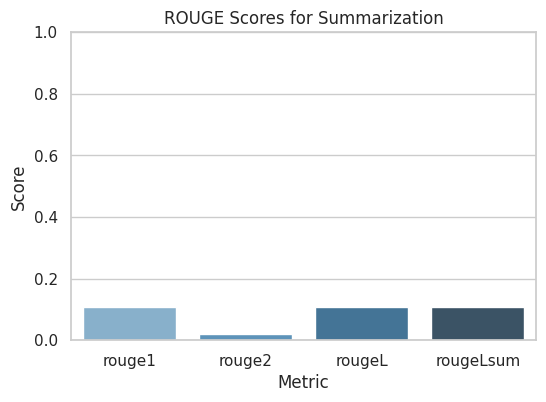

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Convert to DataFrame for plotting
df_rouge = pd.DataFrame({
    'Metric': list(rouge_scores.keys()),
    'Score': [rouge_scores[m] for m in rouge_scores]
})

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Score', data=df_rouge, palette='Blues_d')
plt.ylim(0,1)
plt.title("ROUGE Scores for Summarization")
plt.ylabel("Score")
plt.show()
